# Inferential statistics II - Bootstrapping

## Introduction

In the previous exercises you performed frequentist calculations to perform inference from a sample of data. Such inference relies on theory largely developed from the 19th Century onwards that is subject to certain assumptions or theoretical limits. These are fine if those assumptions hold in your case, and what you want to do has a known theoretical distribution, for example the mean of a sampling distribution that we looked at.

In these exercises we are once again going to load in the medical charge data but this time we are going to make inferences about the population using bootstrapping, that is simulating repeated re-runs of an experiment. If frequentism is about using assumptions and theoretical results to calculate what we expect to happen were an experiment to be run again and again and again, then bootstrapping is about using computing power to essentially re-run the sample draw again and again and again to see what actually happens.

## Prerequisites

Whilst these exercises do not strictly depend on these concepts, before working through them, you should have completed the preceding assignment and have a good understanding of such frequentist concepts as
* the _z_-statistic
* the _t_-statistic
* the difference and relationship between the two
* the Central Limit Theorem, its assumptions and consequences
* how to estimate the population mean and standard deviation from a sample
* the concept of a sampling distribution of a test statistic, particularly for the mean
* how to combine these concepts to calculate confidence intervals and p-values
* how those confidence intervals and p-values allow you to perform hypothesis (or A/B) tests

To complete these exercises, you should have covered the material on how to calculate bootstrap replicates of summary statistics. Having an appreciation of what confidence intervals and p-values are will be helpful.

In [1]:
import pandas as pd
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt

## Medical charge data set

In [2]:
med_charges = pd.read_csv('insurance2.csv')

In [3]:
print(med_charges.shape)
med_charges.head()

(1338, 8)


,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


In the previous assignment, you used the frequentist approach to estimate the lower limit for the 95% confidence interval on the mean hospital charge. This approach relies on statistical theory that has been developed over the years and is also limited to statistics for which theoretical results on the sampling distribution exist. These results are remarkably useful and applicable much of the time and under a surprisingly wide range of conditions.

Having calculated the 95% lower confidence interval using frequentist theory in the previous exercise, you would like to verify your calculations and check you get consistent results without making the assumptions required before. After all, the distribution of charges really was very non-normal.

__Q:__ Use bootstrap sampling to estimate the same 95% confidence interval lower limit as before.

__A:__

In [4]:
""" 
    These functions are purely for understanding
    how we arrive at the function in the next cell
"""

# One random sampling with replacement, i.e., bootstrapping
def bs_1_sample(data):
    return np.random.choice(data, len(data))

# 10,000 bootstrapped samples as a numpy array
def bs_10000_samples(data):    
    bs_array = np.empty(10000)
    for i in range(10000):
        bs_array[i] = bs_1_sample(data)
    return bs_array

# 10,000 means of 10,000 bootstrapped samples as a numpy array
def bs_10000_samples_means(data):    
    bs_array = np.empty(10000)
    for i in range(10000):
        bs_array[i] = np.mean(bs_1_sample(data))
    return bs_array

In [5]:
# Generalization of the above functions
# a bs sample is the sample drawn from the original dataset
# a replicate is the statistic (like the mean) drawn from the bs sample

def replicates(data, func, size):
    bs_array = np.empty(size)
    for i in range(size):
        bs_array[i] = int(func(np.random.choice(data, len(data)))) # using int for readability
    return bs_array

# for checking if array contains bootstrapped means
np.random.seed(47)
bootstrapped_means_array = replicates(med_charges.charges, np.mean, 10000)
print("sample of bootstrapped means:", bootstrapped_means_array[0:4])

# since we're only calculating the 95% lower confidence interval: 
# np.pecentile requires 5 as the second argument
ci_low = np.percentile(bootstrapped_means_array,5)

print("")
print("lower confidence interval", round(ci_low,1))

sample of bootstrapped means: [13386. 13227. 13445. 13474.]

lower confidence interval 12723.9


If you performed 10000 replicates immediately after setting the random seed to 47, 
you should get the value 12724 here, which compares very well with the value 12725 obtained using the _t_-distribution confidence interval previously.
It is a most pleasant result to see the predictions of classical frequentist theory match with results that are now possible through the number-crunching ability of computers.

Remember in the previous exercise set, we saw there are two ways of performing a _t_-test from a sample, depending on whether we can assume the groups have equal variance or not. We can actually easily test this using the bootstrap!

__Q:__ Calculate the 95% confidence interval for the difference between the standard deviations of insurance and non-insurance claim charges (insured - non-insured). Calculate the differences over 10000 replicates. Plot the histogram of values and mark the locations of the percentiles. <font color = red>State the null and alternative hypothesis and 
comment on whether you would retain or reject the null hypothesis in this case and why.</font>

__A:__

In [6]:
np.random.seed(47)
yes_ins = replicates(med_charges.charges[med_charges.insuranceclaim==1], np.std, 10000)
not_ins = replicates(med_charges.charges[med_charges.insuranceclaim==0], np.std, 10000)
diff = yes_ins - not_ins

# to calculate 95% confidence interval,
# np.percentile will take 2.5 and 97.5 (97.5 - 2.5 = 95) respectively in the second argument position
ci_low = np.percentile(diff, 2.5)
ci_high = np.percentile(diff, 97.5)

print(ci_low,"to",ci_high)

6684.0 to 8501.0


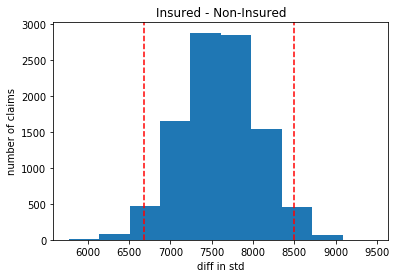

In [7]:
_ = plt.hist(diff)
_ = plt.xlabel('diff in std')
_ = plt.ylabel('number of claims')
_ = plt.title('Insured - Non-Insured')
_ = plt.axvline(ci_low, color='r', linestyle='--')
_ = plt.axvline(ci_high, color='r', linestyle='--')

null hypothesis = no significant difference between groups (insured vs non-insured)

alt = sign. diff. (insured or non-insured are getting sign. diff. charges)

if ci doesn't contain 0 => significant difference

therefore, reject the null hypothesis

## Confidence interval and p-value

The confidence interval above is often a useful quantity to estimate. If we wish to limit our expected probability of making a Type II error (where we wrongly reject the null hypothesis, and it is, instead, true) to $\alpha$, the associated confidence interval is our estimate of the interval within which we expect the true population value to be found $100\times(1 - \alpha)$% of the time we do this test. In the above we performed bootstrap replicates to estimate the interval and <font color=red> reject the null hypothesis if this interval did not contain zero.</font> You will sometimes see such an interval reported in the output of statistical functions.

The partner of the confidence interval is the p-value. The p-value and the confidence interval are linked through our choice of $\alpha$. The p-value tells us how likely it is, under the null hypothesis, to get an outcome at least as extreme as what was observed. If this fails to reach the level of our _pre-specified_ $\alpha$, we decide the null hypothesis is sufficiently unlikely to be true and thus reject it. To calculate this p-value via the bootstrap, we have to put ourselves in a position where we are simulating the null hypothesis being true and then calculate the fraction of times we observe a result at least as extreme as that actually observed.

Remember how, previously, you used the _t_-test to calculate the p-value for the observed difference between the means of insured and non-insured medical cases. We're now going to repeat this but using the bootstrap.

__Q:__ Perform a <font color=red> bootstrapped hypothesis test at the 5% significance level ($\alpha = 0.05$) to calculate the p-value </font> of the observed difference between insurance and non-insurance charges, state your null and alternative hypotheses and whether you retain or reject the null hypothesis for the given significance level.

__A:__

In [8]:
def permutation_sample(data1, data2):
    
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1,data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1,data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1,perm_sample_2)

    return perm_replicates

def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2
    diff = np.mean(data_1) - np.mean(data_2)

    return diff

In [9]:
empirical_diff_means = diff_of_means(med_charges.charges[med_charges.insuranceclaim==1], 
                                                         med_charges.charges[med_charges.insuranceclaim==0])

# Draw 10,000 permutation replicates
permutated_replicates = draw_perm_reps(med_charges.charges[med_charges.insuranceclaim==1], 
                                 med_charges.charges[med_charges.insuranceclaim==0], 
                                 diff_of_means, size=10000)

# Compute p-value: p
p = np.sum(permutated_replicates >= empirical_diff_means ) / len(permutated_replicates)

# Print the result
print("empirical_diff_means:", int(empirical_diff_means))
print("permutated_replicates range:", int(np.min(permutated_replicates)), "to", int(np.max(permutated_replicates)))
print("p-value is {:0.3f}".format(p))

empirical_diff_means: 7602
permutated_replicates range: -2512 to 2729
p-value is 0.000


reject the null hypothesis

__Q:__ To put the above result in perspective, plot the histogram of your bootstrapped differences along with lines marking the locations of the observed difference. <font color=red>(Why would we plot more than one line, given that we only have one observed difference?)</font>

__A:__

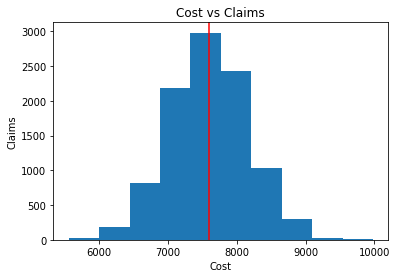

In [11]:
yes_ins = replicates(med_charges.charges[med_charges.insuranceclaim==1], np.mean, 10000)
not_ins = replicates(med_charges.charges[med_charges.insuranceclaim==0], np.mean, 10000)
bs_diff_means = yes_ins - not_ins

_ = plt.hist(bs_diff_means)
_ = plt.axvline(empirical_diff_means, c="red")
_ = plt.title('Cost vs Claims')
_ = plt.xlabel('Cost')
_ = plt.ylabel('Claims')

__Q:__ Compare your p-value above with that obtained using the _t_-test function in the previous assignment. Do you think you would want to try to perform enough bootstrap replicates to observe a random difference as large as that we did observe?

__A:__

I would not since it is unlikely to occur.

__Q:__ Remember the two variants of the _t_-test we performed in the previous assignment. Which one would you use now?

__A:__

two-sided test

__Q:__ If, instead of being asked whether the means of two groups were different, you were working with an ad-recommender team who wanted to release a new recommendation algorithm, and you were looking at click-through rate both for the current algorithm (call it A) and from trials of their new algorithm (call it B), would you perform a two-sided test as above? What would be your null and alternative hypotheses and what would be the real world consequence of rejecting the null hypothesis?

__A:__

When we choose a one-sided alternative instead of a two-sided test, we gain power in one direction of the alternative hypothesis, but completely lose the ability to detect a difference on the other side. Therefore, I only ever believe in using a two-sided test.

For example, in this case, it is possible that what makes algo current algo worse than the new algo is a factor that can be manipulated to make a another algo, call it C, that is better than both algo A and B.

Null hypo = algo A == algo B 

Alt hypo = algo A != algo B

rejecting the null hypo would mean that the current algo may be better than or worse than new algo, so if it is better a change would be needed

# Learning outcomes

You've previously applied frequentist methods to calculate confidence intervals, p-values, and perform hypothesis tests. Frequentist methods use theoretical results to calculate what we expect would happen if experiments were to be run again and again and again. Now you've seen how you can do the same things using the bootstrap approach, which does not rely on such theory, and attendant assumptions, but instead literally does run experiments again and again and again.

In these exercises, you have
* calculated the same confidence interval lower limit as you did previously
* tested the assumption that the variances of the two groups (insured vs. non-insured) were equal - something a bit harder to do using the frequentist method because of the nature of the sampling distribution for variance
* calculated the p-value for the difference between the means of the two groups and compared with the result obtained using the previous frequentist approach

You are now well equipped to apply the bootstrap approach to a wide variety of problems. Just think about what conditions you wish to recreate in your simulated reruns.